# Environment check

In [1]:
import sys, os, platform, time
import torch, torchvision

print("Python:", sys.version)
print("OS:", platform.platform())
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))
else:
    print("NO GPUs; Run on CPU instead.")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Python: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
OS: Linux-6.8.0-85-generic-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu128
Torchvision: 0.23.0+cu128
CUDA available: True
CUDA device count: 2
CUDA device name: NVIDIA RTX 6000 Ada Generation


'cuda'

# Imports and global config

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Assignment hyperparameters
BATCH_SIZE = 128
LR = 3e-3
EPOCHS = 3000
N_CLASSES = 2
N_CHANNELS = 2   # C for BCI IIIb
T_SAMPLES = 750  # T per trial

print(f"HP: batch={BATCH_SIZE}, lr={LR}, epochs={EPOCHS}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== Path ====
DATA_ROOT = Path("/home/i-am-ai/Databases/AIML_Lab/EEG_classification/data")  

HP: batch=128, lr=0.003, epochs=3000
Using device: cuda


# Load data, split train/val, and exploration

In [3]:
def read_bci_data(data_dir: str = DATA_ROOT) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load BCI Competition IIIb data from four npz files and return arrays:
    - train_data: (N_train, 1, C, T)
    - train_label: (N_train,)
    - test_data: (N_test, 1, C, T)
    - test_label: (N_test,)
    Labels are 0/1 (converted from 1/2).
    """
    files = {
        "S4b_train": os.path.join(data_dir, "S4b_train.npz"),
        "X11b_train": os.path.join(data_dir, "X11b_train.npz"),
        "S4b_test": os.path.join(data_dir, "S4b_test.npz"),
        "X11b_test": os.path.join(data_dir, "X11b_test.npz"),
    }
    for k, p in files.items():
        if not os.path.exists(p):
            raise FileNotFoundError(f"Missing file: {p}")

    S4b_train = np.load(files["S4b_train"])
    X11b_train = np.load(files["X11b_train"])
    S4b_test  = np.load(files["S4b_test"])
    X11b_test = np.load(files["X11b_test"])

    train_data = np.concatenate((S4b_train["signal"], X11b_train["signal"]), axis=0)  # (N, T, C)
    train_label = np.concatenate((S4b_train["label"], X11b_train["label"]), axis=0)
    test_data  = np.concatenate((S4b_test["signal"],  X11b_test["signal"]),  axis=0)
    test_label = np.concatenate((S4b_test["label"],  X11b_test["label"]),  axis=0)

    # Convert labels from {1,2} -> {0,1}
    train_label = train_label.astype(np.int64) - 1
    test_label  = test_label.astype(np.int64) - 1

    # Expand to (N, 1, T, C) then transpose to (N, 1, C, T) to match EEGNet convention
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data  = np.transpose(np.expand_dims(test_data,  axis=1), (0, 1, 3, 2))

    # Replace NaNs with global mean
    if np.isnan(train_data).any():
        train_mean = np.nanmean(train_data)
        train_data = np.nan_to_num(train_data, nan=train_mean)
    if np.isnan(test_data).any():
        test_mean = np.nanmean(test_data)
        test_data = np.nan_to_num(test_data, nan=test_mean)

    print("Loaded data shapes:")
    print("  train_data:", train_data.shape, "train_label:", train_label.shape)
    print("  test_data: ", test_data.shape,  "test_label: ", test_label.shape)

    return train_data, train_label, test_data, test_label

Loaded data shapes:
  train_data: (1080, 1, 2, 750) train_label: (1080,)
  test_data:  (1080, 1, 2, 750) test_label:  (1080,)
Counts:
  Train: {0: 540, 1: 540}
  Test:  {0: 540, 1: 540}
  Split -> train(864), val(216), test(1080)


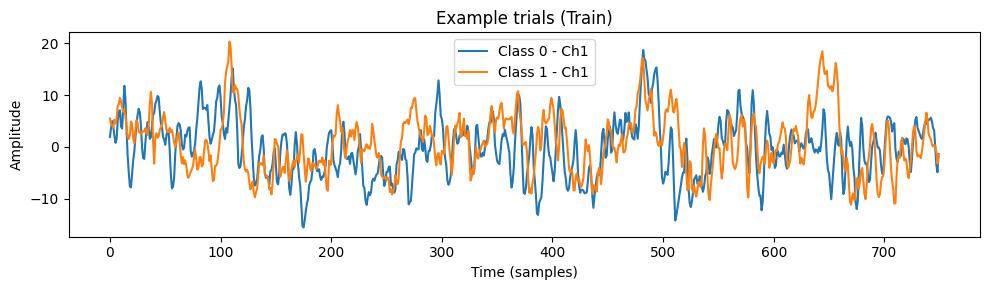

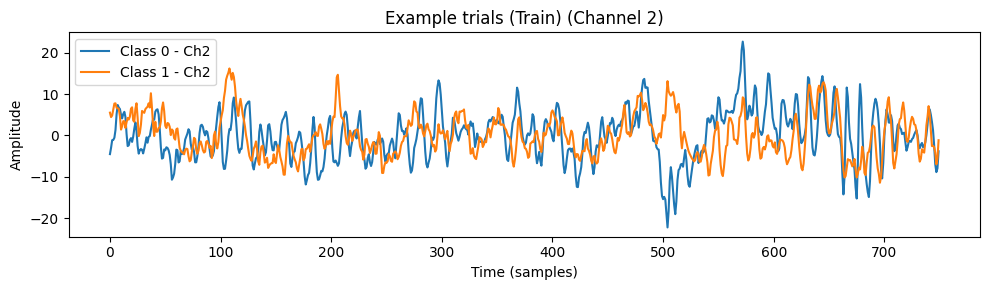

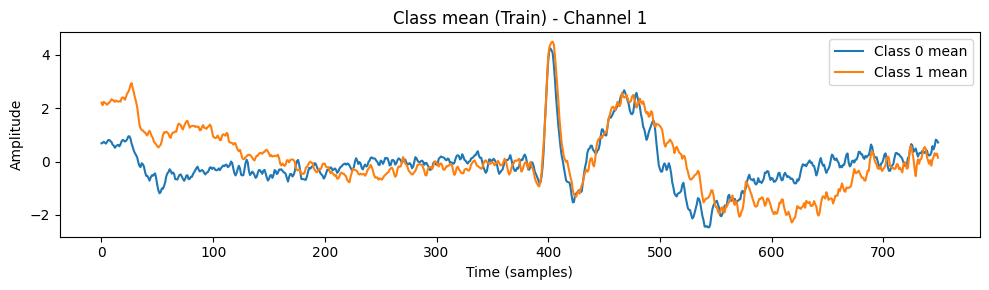

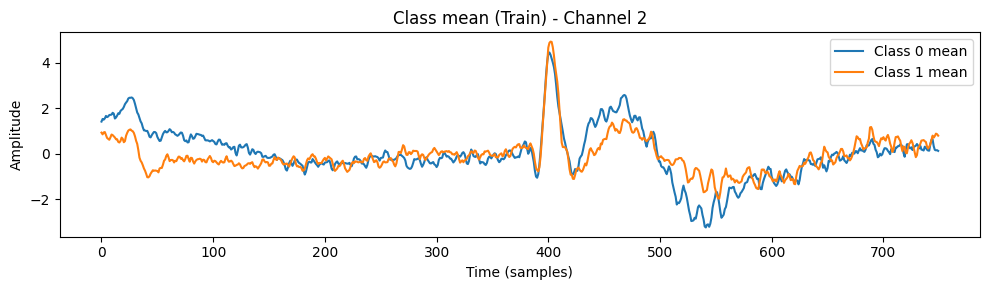

In [4]:
# Load
train_data_np, train_label_np, test_data_np, test_label_np = read_bci_data()

# Torch datasets
class BCIDataset(Dataset):
    def __init__(self, data: np.ndarray, label: np.ndarray):
        # Store as torch tensors
        self.data = torch.tensor(data, dtype=torch.float32)   # (N, 1, C, T)
        self.label = torch.tensor(label, dtype=torch.long)    # (N,)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

full_train_ds = BCIDataset(train_data_np, train_label_np)
test_ds       = BCIDataset(test_data_np,  test_label_np)

# Split train into train/val (80/20)
val_ratio = 0.2
n_full = len(full_train_ds)
n_val = int(round(n_full * val_ratio))
n_train = n_full - n_val
train_ds, val_ds = random_split(full_train_ds, [n_train, n_val])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

# --- Simple two-class exploration ---
def class_counts(labels: np.ndarray):
    uniq, cnt = np.unique(labels, return_counts=True)
    return dict(zip(uniq.tolist(), cnt.tolist()))

print("Counts:")
print("  Train:", class_counts(train_label_np))
print("  Test: ", class_counts(test_label_np))
print(f"  Split -> train({len(train_ds)}), val({len(val_ds)}), test({len(test_ds)})")

# Plot one example from each class and channel
def plot_example_waveforms(data_np, labels_np, title="Example trials by class"):
    # Find one index per class (0 and 1)
    idx0 = int(np.where(labels_np == 0)[0][0])
    idx1 = int(np.where(labels_np == 1)[0][0])
    ex0 = data_np[idx0]  # (1, C, T)
    ex1 = data_np[idx1]

    t = np.arange(ex0.shape[-1])
    plt.figure(figsize=(10,3))
    plt.title(title)
    # Channel 1
    plt.plot(t, ex0[0,0,:], label="Class 0 - Ch1")
    plt.plot(t, ex1[0,0,:], label="Class 1 - Ch1")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3))
    plt.title(title + " (Channel 2)")
    # Channel 2 (if exists)
    plt.plot(t, ex0[0,1,:], label="Class 0 - Ch2")
    plt.plot(t, ex1[0,1,:], label="Class 1 - Ch2")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_class_mean(data_np, labels_np, title="Class mean waveform (per channel)"):
    # Compute mean across trials per class for each channel
    cls0 = data_np[labels_np == 0]  # (N0, 1, C, T)
    cls1 = data_np[labels_np == 1]  # (N1, 1, C, T)
    m0 = cls0.mean(axis=0)  # (1, C, T)
    m1 = cls1.mean(axis=0)  # (1, C, T)
    t = np.arange(m0.shape[-1])

    for ch in range(m0.shape[1]):
        plt.figure(figsize=(10,3))
        plt.title(f"{title} - Channel {ch+1}")
        plt.plot(t, m0[0, ch, :], label="Class 0 mean")
        plt.plot(t, m1[0, ch, :], label="Class 1 mean")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_example_waveforms(train_data_np, train_label_np, title="Example trials (Train)")
plot_class_mean(train_data_np, train_label_np, title="Class mean (Train)")

In [5]:
# --- Minimal per-trial mean-centering (no scaling) ---
def mean_center_per_trial(x_np: np.ndarray) -> np.ndarray:
    # x_np: (N, 1, C, T)
    # Subtract the per-trial, per-channel mean along time
    m = x_np.mean(axis=-1, keepdims=True)
    return x_np - m

# Apply just after loading, before building datasets
train_data_np = mean_center_per_trial(train_data_np)
test_data_np  = mean_center_per_trial(test_data_np)

# Rebuild datasets with the centered arrays
full_train_ds = BCIDataset(train_data_np, train_label_np)
test_ds       = BCIDataset(test_data_np,  test_label_np)

# Make the split reproducible (random_split uses global RNG)
set_seed(42)  # ensure deterministic split each run
n_full = len(full_train_ds)
n_val = int(0.2 * n_full)
n_train = n_full - n_val
train_ds, val_ds = random_split(full_train_ds, [n_train, n_val])

# DataLoaders (unchanged)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

# EEGNet

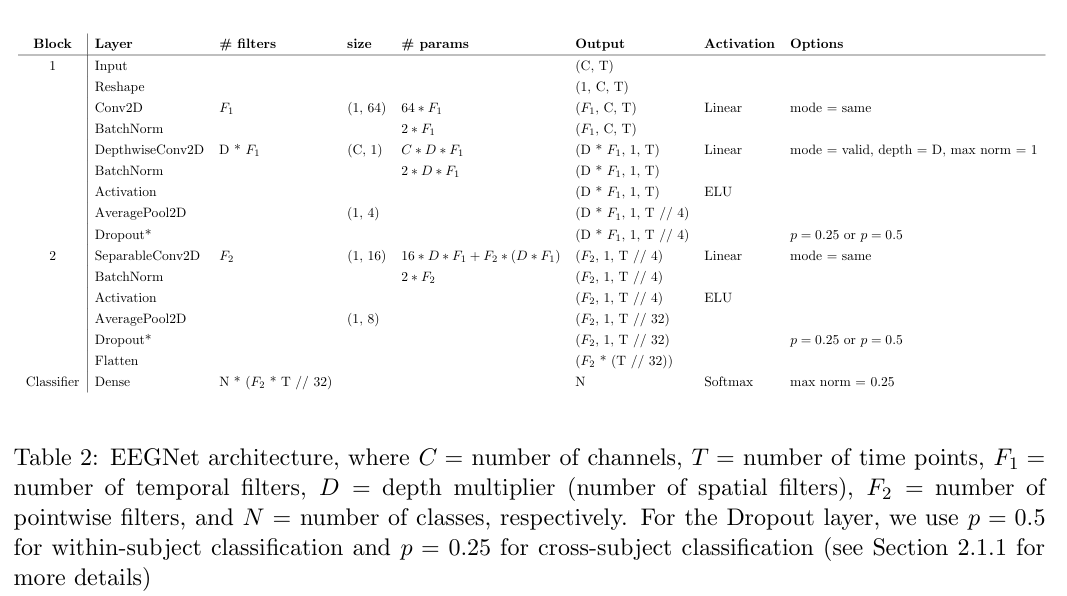

In [6]:
class EEGNet(nn.Module):
    """
    PyTorch implementation of EEGNet (Lawhern et al., 2018), and Table 2 of the paper.
    
    """

    def __init__(self,
                 n_classes: int,
                 n_channels: int,
                 input_time_samples: int,
                 F1: int = 16,
                 D: int = 2,
                 kernel_length: int = 51,        # TA slides: 51; paper default: 64 (for 128 Hz)
                 sep_kernel_length: int = 15,     # TA slides: 15; paper default: 16
                 dropout: float = 0.25,
                 elu_alpha: float = 1.0):
        super().__init__()
        self.n_channels = n_channels
        self.T = input_time_samples
        F2 = F1 * D

        # ----- Block 1: temporal conv -> depthwise spatial conv -----
        # Temporal convolution (along the time axis), linear; no bias (the paper also uses no bias).
        self.conv_time = nn.Conv2d(
            in_channels=1, out_channels=F1,
            kernel_size=(1, kernel_length),
            padding=(0, kernel_length // 2),  # "same" padding along time
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(F1, affine=True)

        # Depthwise convolution (DW): spatial filtering across channels C
        self.conv_spat = nn.Conv2d(
            in_channels=F1, out_channels=F2,
            kernel_size=(n_channels, 1),      # "valid" along channels; output height = 1
            groups=F1,                        # Each temporal filter learns D spatial filters
            bias=False
        )
        self.bn_spat = nn.BatchNorm2d(F2, affine=True)
        self.act1 = nn.ELU(alpha=elu_alpha)  
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.drop1 = nn.Dropout(p=dropout)

        # ----- Block 2: depthwise-temporal + pointwise (separable conv) -----
        self.conv_dw = nn.Conv2d(
            in_channels=F2, out_channels=F2,
            kernel_size=(1, sep_kernel_length),
            padding=(0, sep_kernel_length // 2),
            groups=F2, bias=False             # DW along time
        )
        self.conv_pw = nn.Conv2d(
            in_channels=F2, out_channels=F2,
            kernel_size=(1, 1), bias=False    # 1x1 pointwise conv to mix feature maps
        )
        self.bn2 = nn.BatchNorm2d(F2, affine=True)
        self.act2 = nn.ELU(alpha=elu_alpha)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        self.drop2 = nn.Dropout(p=dropout)

        # ----- Classifier -----
        # Flattened dimension = F2 * (T // 32) (two pooling layers: 4 × 8)
        T_out = input_time_samples // 32
        in_features = F2 * T_out
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features, n_classes, bias=True)

        # ----- Initialization -----
        self._init_weights()

        # Record max-norm hyperparameters in advance (Table 2)
        self.maxnorm_spatial = 1.0   # spatial filtering
        self.maxnorm_fc = 0.25       # Dense

    # -- Weight initialization: original Keras implementation often uses Glorot/Xavier;
    #    here we consistently use xavier_uniform --
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    # -- Implement max-norm constraints per Table 2 (project dynamically during forward) --
    @torch.no_grad()
    def _enforce_max_norm(self):
        # Spatial filter conv_spat: weight shape (F2, F1/groups=1, C, 1)
        w = self.conv_spat.weight.data  # (F2, 1, C, 1)
        w_flat = w.view(w.size(0), -1)  # one vector per out channel
        norms = w_flat.norm(p=2, dim=1, keepdim=True)
        desired = norms.clamp(max=self.maxnorm_spatial)
        w_flat.mul_(desired / (norms + 1e-8))
        self.conv_spat.weight.data = w_flat.view_as(w)

        # Dense: (out_features, in_features); apply max-norm per output unit
        wf = self.fc.weight.data
        norms = wf.norm(p=2, dim=1, keepdim=True)
        desired = norms.clamp(max=self.maxnorm_fc)
        self.fc.weight.data.mul_(desired / (norms + 1e-8))

    # -- Feature pathway --
    def _forward_features(self, x):
        # x: (N, 1, C, T)
        x = self.bn1(self.conv_time(x))

        x = self.conv_spat(x)              # (N, F2, 1, T)
        x = self.act1(self.bn_spat(x))
        x = self.drop1(self.pool1(x))      # (N, F2, 1, T/4)

        x = self.conv_dw(x)
        x = self.conv_pw(x)
        x = self.act2(self.bn2(x))
        x = self.drop2(self.pool2(x))      # (N, F2, 1, T/32)

        return self.flatten(x)             # (N, F2 * T/32)

    def forward(self, x):
        # Apply max-norm to conv_spat and Dense per Table 2
        self._enforce_max_norm()
        feat = self._forward_features(x)
        logits = self.fc(feat)             # Return logits when training with CrossEntropyLoss
        return logits

# DeepConvNet

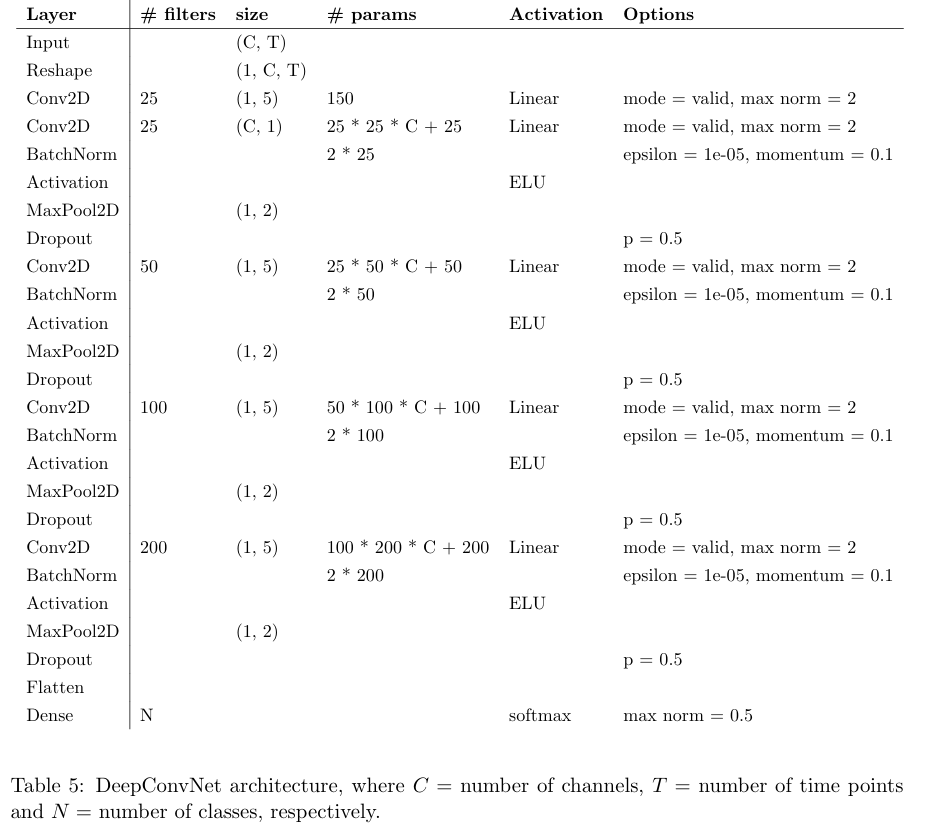

In [7]:
class DeepConvNet(nn.Module):
    """
    DeepConvNet for input (N, 1, C, T), spec per EEGNet appendix Table 5:
      - 4 conv blocks: [Conv -> (optional spatial Conv) -> BN -> ELU -> MaxPool(1,2) -> Dropout(0.5)]
      - First block is split into temporal (1,5) then spatial (C,1)
      - All convolutions are VALID (no padding)
      - Flatten -> Linear (logits for N classes)
      - Max-norm constraints are intentionally omitted.
    """
    def __init__(self,
                 n_classes: int = 2,
                 n_channels: int = 2,
                 temporal_kernel: int = 5,          # Table 5: size = (1,5)
                 pool_size: int = 2,                # Table 5: MaxPool(1,2)
                 channels_conv=(25, 50, 100, 200),
                 dropout: float = 0.5
                 ):
        super().__init__()


        self.act = nn.ELU()

        c1, c2, c3, c4 = channels_conv

        # Block 1: temporal then spatial conv (both VALID)
        self.conv1_time = nn.Conv2d(1, c1, kernel_size=(1, temporal_kernel), bias=True)
        self.conv1_spat = nn.Conv2d(c1, c1, kernel_size=(n_channels, 1), bias=True)
        self.bn1 = nn.BatchNorm2d(c1, eps=1e-5, momentum=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, pool_size))
        self.drop1 = nn.Dropout(dropout)

        # Block 2
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=(1, temporal_kernel), bias=True)
        self.bn2 = nn.BatchNorm2d(c2, eps=1e-5, momentum=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, pool_size))
        self.drop2 = nn.Dropout(dropout)

        # Block 3
        self.conv3 = nn.Conv2d(c2, c3, kernel_size=(1, temporal_kernel), bias=True)
        self.bn3 = nn.BatchNorm2d(c3, eps=1e-5, momentum=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, pool_size))
        self.drop3 = nn.Dropout(dropout)

        # Block 4
        self.conv4 = nn.Conv2d(c3, c4, kernel_size=(1, temporal_kernel), bias=True)
        self.bn4 = nn.BatchNorm2d(c4, eps=1e-5, momentum=0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=(1, pool_size))
        self.drop4 = nn.Dropout(dropout)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_channels, T_SAMPLES)
            feat = self._forward_features(dummy)
            in_features = feat.shape[1]

        self.fc = nn.Linear(in_features, n_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def _forward_features(self, x):
        x = self.conv1_time(x)
        x = self.conv1_spat(x)
        x = self.bn1(x); x = self.act(x); x = self.pool1(x); x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x); x = self.act(x); x = self.pool2(x); x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x); x = self.act(x); x = self.pool3(x); x = self.drop3(x)

        x = self.conv4(x)
        x = self.bn4(x); x = self.act(x); x = self.pool4(x); x = self.drop4(x)

        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        return self.fc(x)  

# Training & evaluation utilities

In [8]:
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    # Compute accuracy in percentage
    preds = logits.argmax(dim=1)
    return 100.0 * (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device):
    # Return average loss and accuracy
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += y.numel()
    avg_loss = total_loss / total
    acc = 100.0 * total_correct / total
    return avg_loss, acc

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device: torch.device
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,500,1000], gamma=0.1)
    
    history = {
        "train_loss": [],
        "train_acc":  [],
        "val_loss":   [],
        "val_acc":    [],
        "best_state": None,
        "best_val_acc": 0.0
    }

    model.to(device)
    criterion.to(device)

    for ep in range(1, epochs + 1):
        model.train()
        run_loss = 0.0
        run_correct = 0
        run_total = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            run_loss   += loss.item() * y.size(0)
            run_correct += (logits.argmax(1) == y).sum().item()
            run_total  += y.numel()

        train_loss = run_loss / run_total
        train_acc  = 100.0 * run_correct / run_total

        val_loss, val_acc = evaluate(model, val_loader, device)

        # Print training/validation loss each epoch as requested
        print(f"Epoch {ep:03d}/{epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} | train_acc={train_acc:5.2f}% val_acc={val_acc:5.2f}%")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > history["best_val_acc"]:
            history["best_val_acc"] = val_acc
            history["best_state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Save best weights
    if history["best_state"] is not None:
        torch.save(history["best_state"], "weights/eegnet_best.pt")

    return history

# --- Metrics for test evaluation (binary) ---

@torch.no_grad()
def get_logits_and_targets(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    all_logits = []
    all_targets = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y)
    return torch.cat(all_logits, dim=0), torch.cat(all_targets, dim=0)

def confusion_matrix_binary(y_pred: np.ndarray, y_true: np.ndarray):
    # y_pred, y_true in {0,1}
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    return np.array([[tn, fp], [fn, tp]])

def precision_recall_f1_from_cm(cm: np.ndarray):
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    acc       = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    return precision, recall, f1, acc

def roc_curve_manual(y_true: np.ndarray, y_score: np.ndarray):
    """
    Compute ROC curve points (FPR, TPR) by sweeping thresholds over unique scores.
    y_true in {0,1}; y_score are continuous [0,1] probabilities for class=1.
    """
    # Sort unique thresholds descending
    thresholds = np.unique(y_score)[::-1]
    P = (y_true == 1).sum()
    N = (y_true == 0).sum()
    fprs, tprs = [], []

    # Ensure curve starts at (0,0) and ends at (1,1)
    thresholds = np.r_[np.inf, thresholds, -np.inf]

    for thr in thresholds:
        y_hat = (y_score >= thr).astype(int)
        tp = ((y_hat == 1) & (y_true == 1)).sum()
        fp = ((y_hat == 1) & (y_true == 0)).sum()
        tpr = tp / (P + 1e-12)
        fpr = fp / (N + 1e-12)
        fprs.append(fpr)
        tprs.append(tpr)
    return np.array(fprs), np.array(tprs)

def auc_trapezoid(x: np.ndarray, y: np.ndarray):
    # Assumes x is monotonic (e.g., FPR sequence), integrate y w.r.t x
    idx = np.argsort(x)
    x_sorted = x[idx]
    y_sorted = y[idx]
    area = np.trapezoid(y_sorted, x_sorted)
    return float(area)

def plot_training_curves(history, prefix="eegnet"):
    # Plot loss and accuracy for train/val
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"],   label="Val")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
    plt.savefig(f"figs/{prefix}_loss.png", dpi=150)
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"],   label="Val")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.tight_layout()
    plt.savefig(f"figs/{prefix}_acc.png", dpi=150)
    plt.show()

def plot_confusion_matrix(cm: np.ndarray, classes=("0","1"), title="Confusion Matrix"):
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1], [f"Pred {c}" for c in classes])
    plt.yticks([0,1], [f"True {c}" for c in classes])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

def plot_roc(fpr: np.ndarray, tpr: np.ndarray, auc_val: float, title="ROC Curve"):
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], linestyle="--", label="Chance")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig("figs/roc_curve.png", dpi=150)
    plt.show()

# Training and visualization

In [9]:
# === Train EEGNet ===
set_seed(42)
model = EEGNet(n_classes=N_CLASSES, n_channels=N_CHANNELS, input_time_samples=T_SAMPLES,
               F1=16, D=2, kernel_length=64, sep_kernel_length=16,
               dropout=0.5, elu_alpha=1.0).to(device)

model

EEGNet(
  (conv_time): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_spat): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
  (bn_spat): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv_dw): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=32, bias=False)
  (conv_pw): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (drop2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=736, out_features=2, b

Epoch 001/3000 | train_loss=0.6490 val_loss=0.6407 | train_acc=59.03% val_acc=72.22%
Epoch 002/3000 | train_loss=0.5603 val_loss=0.5656 | train_acc=71.53% val_acc=70.37%
Epoch 003/3000 | train_loss=0.5477 val_loss=0.5579 | train_acc=71.64% val_acc=69.44%
Epoch 004/3000 | train_loss=0.5419 val_loss=0.5321 | train_acc=71.18% val_acc=72.69%
Epoch 005/3000 | train_loss=0.5365 val_loss=0.5215 | train_acc=72.34% val_acc=73.15%
Epoch 006/3000 | train_loss=0.5249 val_loss=0.5154 | train_acc=73.61% val_acc=73.15%
Epoch 007/3000 | train_loss=0.5276 val_loss=0.5205 | train_acc=72.92% val_acc=72.69%
Epoch 008/3000 | train_loss=0.5331 val_loss=0.5167 | train_acc=74.42% val_acc=71.30%
Epoch 009/3000 | train_loss=0.5207 val_loss=0.5132 | train_acc=73.15% val_acc=72.22%
Epoch 010/3000 | train_loss=0.5175 val_loss=0.4971 | train_acc=73.50% val_acc=73.61%
Epoch 011/3000 | train_loss=0.5061 val_loss=0.5057 | train_acc=75.81% val_acc=73.61%
Epoch 012/3000 | train_loss=0.5064 val_loss=0.5116 | train_acc=75

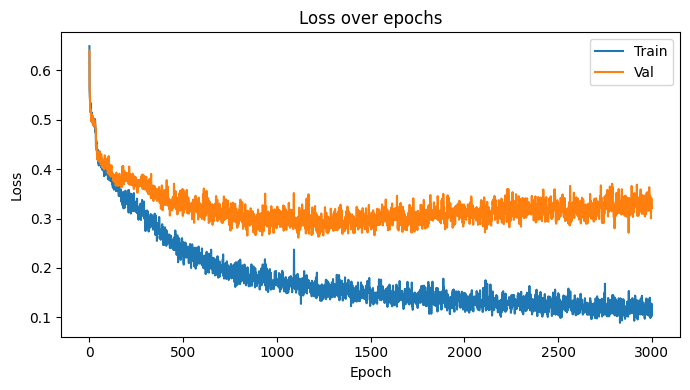

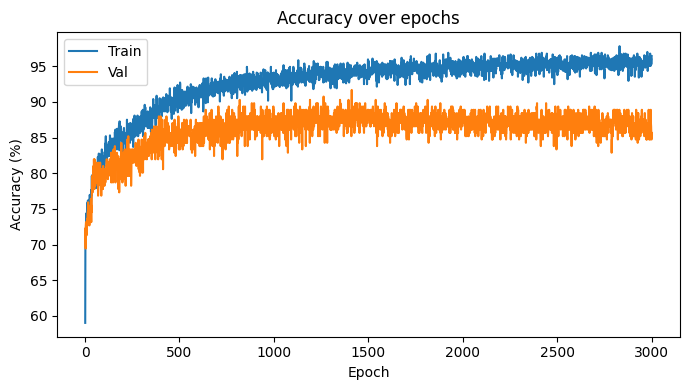

In [10]:
history = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device=device)

# Load best state (by validation accuracy) and plot curves
if history["best_state"] is not None:
    model.load_state_dict(history["best_state"])
plot_training_curves(history, prefix="eegnet")

Test Accuracy: 87.41%
Test F1:       0.8755
Test AUC:      0.9485


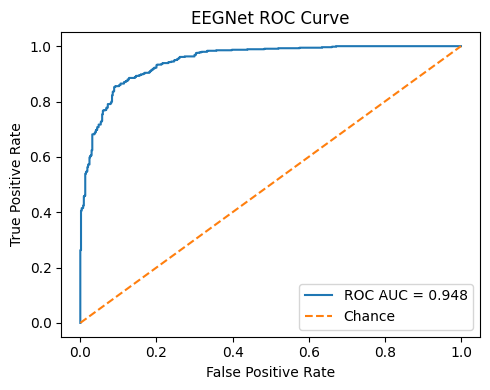

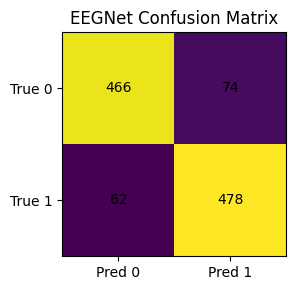

In [11]:
# Collect logits and targets
logits_test, targets_test = get_logits_and_targets(model, test_loader, device)
probs_test = torch.softmax(logits_test, dim=1).numpy()  # (N, 2)
scores_pos = probs_test[:, 1]                           # probability of class 1
preds_test = probs_test.argmax(axis=1)                  # argmax predictions
targets_np = targets_test.numpy()

# Confusion matrix & metrics
cm = confusion_matrix_binary(preds_test, targets_np)
precision, recall, f1, acc = precision_recall_f1_from_cm(cm)

# ROC curve & AUC
fpr, tpr = roc_curve_manual(targets_np, scores_pos)
auc_val = auc_trapezoid(fpr, tpr)

# Print requested metrics
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test F1:       {f1:.4f}")
print(f"Test AUC:      {auc_val:.4f}")

# Plot ROC and Confusion Matrix
plot_roc(fpr, tpr, auc_val, title="EEGNet ROC Curve")
plot_confusion_matrix(cm, classes=("0","1"), title="EEGNet Confusion Matrix")

In [12]:
# === Train DeepConvNet (flatten head) ===
set_seed(42)
model = DeepConvNet(n_classes=N_CLASSES, n_channels=N_CHANNELS,
                    temporal_kernel=10, pool_size=3,
                    channels_conv=(25, 50, 100, 200),
                    dropout=0.5).to(device)

model

DeepConvNet(
  (act): ELU(alpha=1.0)
  (conv1_time): Conv2d(1, 25, kernel_size=(1, 10), stride=(1, 1))
  (conv1_spat): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
  (bn1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(1, 10), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(1, 10), stride=(1, 1))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(100, 200,

Epoch 001/2250 | train_loss=1.2056 val_loss=0.7553 | train_acc=49.54% val_acc=57.41%
Epoch 002/2250 | train_loss=1.0823 val_loss=0.7020 | train_acc=52.66% val_acc=58.33%
Epoch 003/2250 | train_loss=1.0433 val_loss=0.6925 | train_acc=54.05% val_acc=61.57%
Epoch 004/2250 | train_loss=0.9127 val_loss=0.6490 | train_acc=59.95% val_acc=66.67%
Epoch 005/2250 | train_loss=0.9112 val_loss=0.6753 | train_acc=60.88% val_acc=61.11%
Epoch 006/2250 | train_loss=0.8959 val_loss=0.6526 | train_acc=61.69% val_acc=67.13%
Epoch 007/2250 | train_loss=0.8480 val_loss=0.6246 | train_acc=63.31% val_acc=64.81%
Epoch 008/2250 | train_loss=0.8052 val_loss=0.6343 | train_acc=63.43% val_acc=64.35%
Epoch 009/2250 | train_loss=0.9035 val_loss=0.6070 | train_acc=61.46% val_acc=68.98%
Epoch 010/2250 | train_loss=0.8109 val_loss=0.6004 | train_acc=64.00% val_acc=65.28%
Epoch 011/2250 | train_loss=0.7919 val_loss=0.6013 | train_acc=62.62% val_acc=64.35%
Epoch 012/2250 | train_loss=0.7943 val_loss=0.6229 | train_acc=63

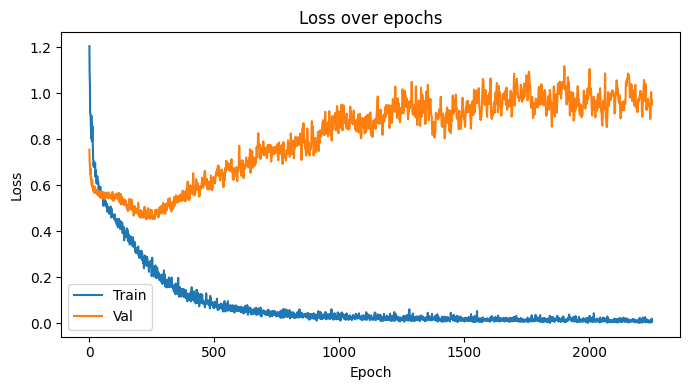

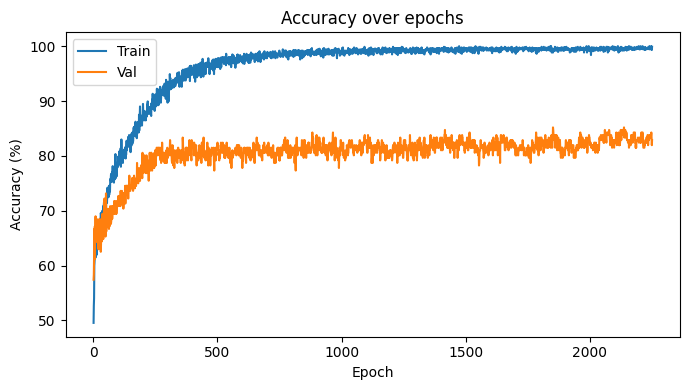

In [13]:
history = train_model(model, train_loader, val_loader, epochs=2250, lr=7e-4, device=device)

if history["best_state"] is not None:
    model.load_state_dict(history["best_state"])
plot_training_curves(history, prefix="deepconvnet_flatten")

Test Accuracy: 84.07%
Test F1:       0.8464
Test AUC:      0.9134


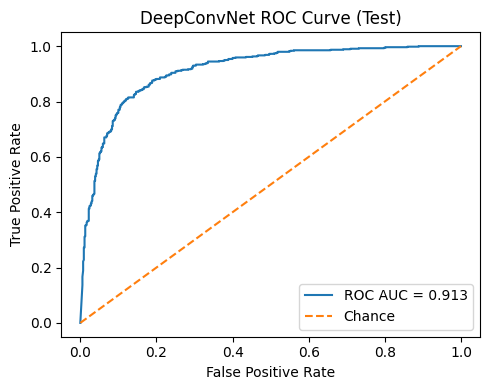

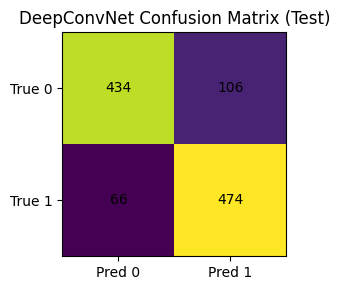

In [14]:
# Collect logits and targets
logits_test, targets_test = get_logits_and_targets(model, test_loader, device)
probs_test = torch.softmax(logits_test, dim=1).numpy()  # (N, 2)
scores_pos = probs_test[:, 1]                           # probability of class 1
preds_test = probs_test.argmax(axis=1)                  # argmax predictions
targets_np = targets_test.numpy()

# Confusion matrix & metrics
cm = confusion_matrix_binary(preds_test, targets_np)
precision, recall, f1, acc = precision_recall_f1_from_cm(cm)

# ROC curve & AUC
fpr, tpr = roc_curve_manual(targets_np, scores_pos)
auc_val = auc_trapezoid(fpr, tpr)

# Print requested metrics
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test F1:       {f1:.4f}")
print(f"Test AUC:      {auc_val:.4f}")

# Plot ROC and Confusion Matrix
plot_roc(fpr, tpr, auc_val, title="DeepConvNet ROC Curve (Test)")
plot_confusion_matrix(cm, classes=("0","1"), title="DeepConvNet Confusion Matrix (Test)")